## Variable étudiée : `DEC_MED21`

Le jeu de données provient de l’**INSEE** et décrit les **ressources économiques des ménages au niveau des IRIS**, unités statistiques infra-communales de 16002 iris.  

On s’intéresse à la variable `DEC_MED21`, qui correspond au **revenu médian annuel** des ménages dans un IRIS.

Par nature, cette variable est **continue**, **strictement positive** et présente une **asymétrie à droite**, caractéristique des distributions de revenus.

On note :
\[
X = \text{DEC\_MED21}, \qquad X > 0
\]

Afin de modéliser la distribution de `DEC_MED21`, on fait l’hypothèse que \(X\) suit une **loi log-normale** :
\[
X \sim \text{LogNormale}(m,\sigma^2)
\quad \Longleftrightarrow \quad
\log(X) \sim \mathcal{N}(m,\sigma^2)
\]

Les paramètres de cette loi seront estimés à partir des données.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy import stats

## Chargement des données et Dataprep

In [2]:
path = "dataset/BASE_TD_FILO_IRIS_2021_DEC.csv"


df = pd.read_csv(path, sep=";", decimal=",")
# Identify columns that contain numerical values with comma
num_cols = [col for col in df.columns if df[col].str.contains(",", na=False).any()]

# Convert them: replace "," -> "." then cast to float
for col in num_cols:
    df[col] = df[col].str.replace(",", ".", regex=False)
    df[col] = pd.to_numeric(df[col], errors="coerce")

#columns with 60% of NAN
col_NaN = [c for c in df.columns if df[c].isnull().mean()*100 > 60.0]
print("number of columns with  60% of NaN",len(col_NaN))

quasi_constant = df.columns[
    df.apply(
        lambda x : x.value_counts(normalize=True).iloc[0]
        if x.dropna().size > 0 else 0
    ) > 0.90
]
print("\n nb de colonnes avec 90 % des données avec la même valeur :", len(quasi_constant))

number of columns with  60% of NaN 0

 nb de colonnes avec 90 % des données avec la même valeur : 0


In [3]:
def audit(df):
    return pd.DataFrame({
        "dtype": df.dtypes,
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "unique": df.nunique(),
        "sample": df.iloc[0]
    })


audit(df)

,dtype,missing,missing_%,unique,sample
IRIS,object,0,0.00,16026,010040101
DEC_PIMP21,float64,1536,9.58,83,43.0
DEC_TP6021,float64,1537,9.59,85,29.0
DEC_INCERT21,object,0,0.00,3,2
DEC_Q121,object,0,0.00,2737,12610
DEC_MED21,object,0,0.00,3498,19330
DEC_Q321,object,0,0.00,4343,26390
DEC_EQ21,float64,1536,9.58,190,0.71
DEC_D121,object,0,0.00,1953,7760
DEC_D221,object,0,0.00,2573,11300


In [4]:
df = df.dropna()
na_counts = df.isna().sum().sort_values(ascending=False)
na_counts

IRIS            0
DEC_PIMP21      0
DEC_TP6021      0
DEC_INCERT21    0
DEC_Q121        0
DEC_MED21       0
DEC_Q321        0
DEC_EQ21        0
DEC_D121        0
DEC_D221        0
DEC_D321        0
DEC_D421        0
DEC_D621        0
DEC_D721        0
DEC_D821        0
DEC_D921        0
DEC_RD21        0
DEC_S80S2021    0
DEC_GI21        0
DEC_PACT21      0
DEC_PTSA21      0
DEC_PCHO21      0
DEC_PBEN21      0
DEC_PPEN21      0
DEC_PAUT21      0
DEC_NOTE21      0
dtype: int64

In [5]:
df.shape

(13674, 26)

In [6]:
df.describe()

,DEC_PIMP21,DEC_TP6021,DEC_EQ21,DEC_RD21,DEC_S80S2021,DEC_GI21,DEC_PACT21,DEC_PTSA21,DEC_PCHO21,DEC_PBEN21,DEC_PPEN21,DEC_PAUT21
count,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000,13674.000000
mean,53.881600,24.743235,0.819758,18.694669,9.932280,0.362767,68.288409,60.762608,3.254073,4.271727,26.124448,5.587143
std,14.230925,13.594410,0.191954,148.426722,6.484679,0.063986,9.691292,9.789245,1.256660,2.418706,8.940358,5.200029
min,7.000000,3.000000,0.410000,2.400000,2.800000,0.198000,19.400000,16.500000,0.400000,0.200000,-0.300000,0.000000
25%,43.000000,14.000000,0.670000,4.500000,5.900000,0.319000,62.300000,54.600000,2.400000,2.500000,19.600000,2.700000
50%,54.000000,22.000000,0.790000,6.200000,8.100000,0.358000,68.800000,61.400000,3.000000,3.800000,25.500000,4.300000
75%,65.000000,33.000000,0.940000,9.200000,11.500000,0.399000,75.100000,67.800000,3.900000,5.500000,31.900000,6.600000
max,91.000000,83.000000,1.870000,6617.000000,150.300000,0.803000,98.200000,96.500000,13.300000,31.700000,66.400000,69.500000


In [7]:
vars_of_interest = [
    "DEC_MED21",    # Revenu médian
]

subset = df[vars_of_interest].copy()
subset.head()


,DEC_MED21
0,19330
1,16830
2,19940
3,25560
4,19870


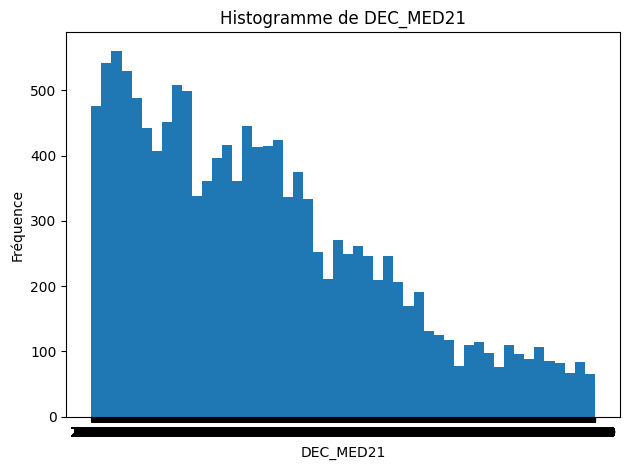

In [8]:
for col in vars_of_interest:
    data = subset[col]
    plt.figure()
    plt.hist(data, bins = 50)
    plt.title(f"Histogramme de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()

On observe que la variable  `DEC_MED21`, le Revenu médian semble suivre une  **loi log-normale**

Nous proposons donc de construire trois estimateurs distincts afin d’estimer cette loie:
1. les estimateurs des maximum de vraissemblance
2. les etimateurs des moments


Vérifions que `DEC_MED21` suis bien une loie log normal pour se faire nous allons dans un premier temps vérifier la distibution de `log(DEC_MED21)` et enfin l'adéquation à une loi normale 

C:\Users\sppre\AppData\Roaming\Python\Python312\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


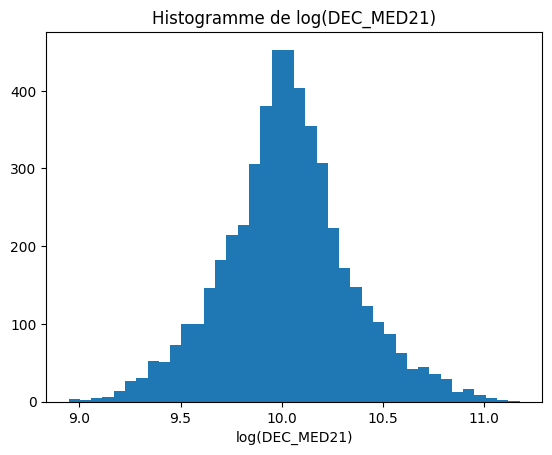

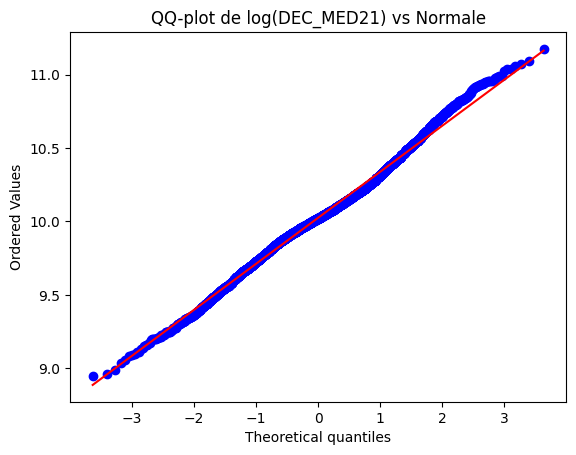

In [9]:
sub = df["DEC_MED21"].dropna().astype(np.number).to_frame()
sub["IRIS"] = df.loc[sub.index, "IRIS"]
sub["DEC_MED21"] = pd.to_numeric(sub["DEC_MED21"], errors="coerce")
sub = sub[sub["DEC_MED21"] > 0]   # indispensable pour le log

# ÉCHANTILLON ALÉATOIRE (ex: 5 000 observations)
sub_sample = sub.sample(n=5000, random_state=42)

# Transformation
x = sub_sample["DEC_MED21"].to_numpy()
logx = np.log(x)

# Histogramme
plt.figure()
plt.hist(logx, bins=40)
plt.title("Histogramme de log(DEC_MED21)")
plt.xlabel("log(DEC_MED21)")
plt.show()

# QQ-plot
plt.figure()
stats.probplot(logx, dist="norm", plot=plt)
plt.title("QQ-plot de log(DEC_MED21) vs Normale")
plt.show()

On a bien log(DEC_MED21) qui suis une loie normale, comme le montrent sa densité et le graphique QQ-plot. On va donc estimer ses paramètres en supposant une loi normale et en effectuant une reparamétrisation par la suite

## Estimation des paramètres d’une loi log-normale

### Estimation par le maximum de vraisemblance

On suppose que la variable aléatoire $X$ suit une loi log-normale. Propriété que nous avons prouvé avec qq plot et la distribution de log(DEC_MED21). 
Par définition, cela signifie que la variable transformée

$$
Y = \log(X)
$$


suit une loi normale de paramètres $m$ et $\sigma^2$, notée :

$$
Y \sim \mathcal{N}(m,\sigma^2)
$$

Soit $(x_1,\ldots,x_n)$ un échantillon i.i.d. issu de la loi de $X$,
avec $x_i > 0$ pour tout $i$.
On définit alors

$$
y_i = \log(x_i),
$$

de sorte que $(y_1,\ldots,y_n)$ est un échantillon i.i.d. issu de
$\mathcal{N}(m,\sigma^2)$.

---

### Fonction de vraisemblance

La densité d’une variable normale $\mathcal{N}(m,\sigma^2)$ est donnée par :

$$
f(y \mid m,\sigma^2)
=
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\left(
-\frac{(y-m)^2}{2\sigma^2}
\right)
$$

La fonction de vraisemblance associée à l’échantillon
$(y_1,\ldots,y_n)$ s’écrit donc :

$$
L(m,\sigma^2)
=
\prod_{i=1}^{n}
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\left(
-\frac{(y_i-m)^2}{2\sigma^2}
\right)
$$

---

### Log-vraisemblance

Afin de simplifier les calculs, on considère la log-vraisemblance :

$$
\ell(m,\sigma^2)
=
\log L(m,\sigma^2)
$$

ce qui donne :

$$
\ell(m,\sigma^2)
=
-\frac{n}{2}\log(2\pi)
-\frac{n}{2}\log(\sigma^2)
-\frac{1}{2\sigma^2}
\sum_{i=1}^{n}(y_i-m)^2
$$

---

### Calcul des estimateurs du maximum de vraisemblance

On dérive la log-vraisemblance par rapport à $m$ :

$$
\frac{\partial \ell}{\partial m}
=
\frac{1}{\sigma^2}
\sum_{i=1}^{n}(y_i-m)
$$

En annulant cette dérivée, on obtient la condition du premier ordre :

$$
\sum_{i=1}^{n}(y_i-m) = 0
\quad \Longrightarrow \quad
\hat{m}
=
\frac{1}{n}
\sum_{i=1}^{n} y_i
$$

On dérive ensuite la log-vraisemblance par rapport à $\sigma^2$ :

$$
\frac{\partial \ell}{\partial \sigma^2}
=
-\frac{n}{2\sigma^2}
+
\frac{1}{2\sigma^4}
\sum_{i=1}^{n}(y_i-m)^2
$$

L’annulation de cette dérivée conduit à l’estimateur :

$$
\hat{\sigma}^2
=
\frac{1}{n}
\sum_{i=1}^{n}(y_i-\hat{m})^2
$$

Afin de vérifier que ces estimateurs correspondent bien à un maximum
de la fonction de log-vraisemblance, on étudie les dérivées secondes.

La dérivée seconde par rapport à $m$ est donnée par :

$$
\frac{\partial^2 \ell}{\partial m^2}
=
-\frac{n}{\sigma^2}
< 0
$$

ce qui montre que la log-vraisemblance est concave en $m$.

De même, la dérivée seconde par rapport à $\sigma^2$ est :

$$
\frac{\partial^2 \ell}{\partial (\sigma^2)^2}
=
-\frac{n}{2(\sigma^2)^2}
< 0
$$

Ainsi, les points critiques obtenus correspondent bien à des maxima
de la log-vraisemblance.


---

In [10]:
# moyenne empirique
moy_emp = np.mean(logx)
#variance empirque 
var_emp = np.var(logx, ddof=1)


print("Moyenne empirique (logx) =", moy_emp)
print("Variance empirique non biaisée (ddof=1) =", var_emp)

Moyenne empirique (logx) = 10.025380193806052
Variance empirique non biaisée (ddof=1) = 0.09862218315695598


In [11]:
n = len(logx)

# moyenne
m_hat_emv = (1/n) * np.sum(logx)

# variance 
sigma2_hat_emv = (1/(n-1)) * np.sum((logx - m_hat_emv)**2)

# écart-type
sigma_hat_emv = np.sqrt(sigma2_hat_emv)

print("Estimateur Maximun de vraissemblance de m :", m_hat_emv)
print("Estimateur max de vraissemblance de sigma :", sigma2_hat_emv)

Estimateur Maximun de vraissemblance de m : 10.025380193806052
Estimateur max de vraissemblance de sigma : 0.09862218315695598


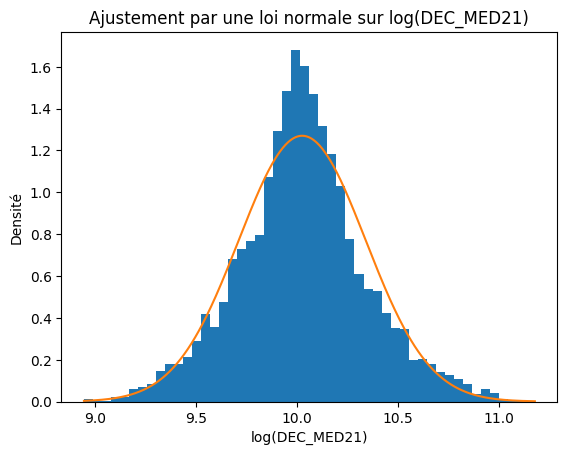

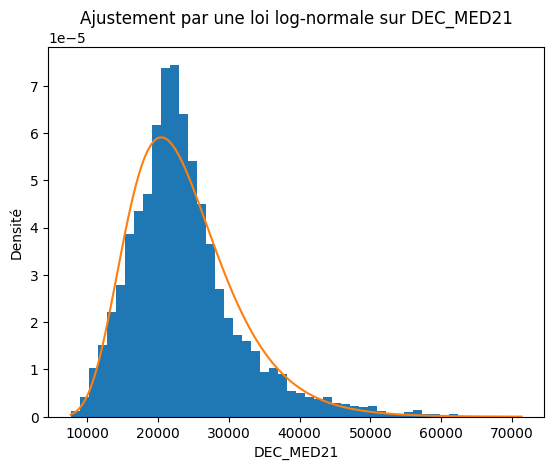

In [12]:
from scipy.stats import norm, lognorm
# grille pour log(X)
x_log = np.linspace(logx.min(), logx.max(), 500)

# densité normale estimée
pdf_normal = norm.pdf(x_log, loc=m_hat_emv, scale=sigma_hat_emv)

plt.figure()
plt.hist(logx, bins=50, density=True)
plt.plot(x_log, pdf_normal)
plt.title("Ajustement par une loi normale sur log(DEC_MED21)")
plt.xlabel("log(DEC_MED21)")
plt.ylabel("Densité")
plt.show()

# grille pour X
x_grid = np.linspace(x.min(), x.max(), 500)

# densité log-normale estimée
pdf_lognorm = lognorm.pdf(x_grid, s=sigma_hat_emv, scale=np.exp(m_hat_emv))

plt.figure()
plt.hist(x, bins=50, density=True)
plt.plot(x_grid, pdf_lognorm)
plt.title("Ajustement par une loi log-normale sur DEC_MED21")
plt.xlabel("DEC_MED21")
plt.ylabel("Densité")
plt.show()


Ces deux grpahes confirment que le revenu médian (DEC_MED21) suit bien une loi log-normale et que nos estimateurs semblent correspondrent à la loie que suit les données. 

#### Estimations par la méthode des moments 


Par définition, si $X \sim \text{Log-Normal}(m, \sigma^2)$, les deux premiers moments théoriques sont :

$$
E[X] = e^{m + \frac{\sigma^2}{2}}
$$

$$
V[X] = (e^{\sigma^2} - 1)e^{2m + \sigma^2}
$$

Soit $(x_1, \dots, x_n)$ un échantillon i.i.d. issu de la loi de $X$. On définit la moyenne empirique $\bar{x}$ et la variance empirique $s^2$ par :

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i \quad \text{et} \quad s^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2
$$

---

### Système d'équations des moments

L'estimation des paramètres consiste à résoudre le système d'équations suivant, où l'on identifie les moments théoriques aux moments empiriques :

$$
\begin{cases} 
e^{m + \frac{\sigma^2}{2}} = \bar{x} & (1) \\
(e^{\sigma^2} - 1)e^{2m + \sigma^2} = s^2 & (2)
\end{cases}
$$

---

### Calcul de l'estimateur de $\sigma^2$

On remarque que le terme $e^{2m + \sigma^2}$ dans l'équation (2) peut s'écrire comme le carré de l'expression de l'espérance issue de l'équation (1) :

$$
(e^{m + \frac{\sigma^2}{2}})^2 = e^{2m + \sigma^2} = \bar{x}^2
$$

En substituant cette égalité dans l'équation (2), on obtient :

$$
(e^{\sigma^2} - 1) \bar{x}^2 = s^2
$$

On isole ensuite le terme exponentiel :

$$
e^{\sigma^2} - 1 = \frac{s^2}{\bar{x}^2} \quad \Longrightarrow \quad e^{\sigma^2} = 1 + \frac{s^2}{\bar{x}^2}
$$

En passant au logarithme, on obtient l'estimateur de la variance :

$$
\hat{\sigma}^2_{MM} = \log\left(1 + \frac{s^2}{\bar{x}^2}\right)
$$

---

### Calcul de l'estimateur de $m$

Pour extraire $m$, on utilise l'équation (1) en y appliquant la fonction logarithme :

$$
m + \frac{\sigma^2}{2} = \log(\bar{x})
$$

En isolant $m$ et en utilisant l'estimateur $\hat{\sigma}^2_{MM}$ précédemment calculé, on trouve :

$$
\hat{m}_{MM} = \log(\bar{x}) - \frac{1}{2} \hat{\sigma}^2_{MM}
$$

En remplaçant par l'expression développée, l'estimateur final est :

$$
\hat{m}_{MM} = \log(\bar{x}) - \frac{1}{2} \log\left(1 + \frac{s^2}{\bar{x}^2}\right)
$$

---

In [13]:
sigma2_hat_mm = np.log(1+ (var_emp/moy_emp**2))

m_hat_mm = np.log(moy_emp) - 0.5*sigma2_hat_mm

sigma_hat_mm = np.sqrt(sigma2_hat_mm)

print("Estimateur des moments de m :", m_hat_mm)
print("Estimateur des moments de sigma :", sigma2_hat_mm)

Estimateur des moments de m : 2.304629520228048
Estimateur des moments de sigma : 0.0009807536292978144


#### Vérifions les propriétes des estimateurs 

si estimateurs sans biais 
verifions la loi forte des grand nombre 

(mettre la formule)
 theorme de la limite centrale 

 (mettre formule )

 verifier si c'est une optimisation optimatle informations de fisher etc